# GEOG5990M Final Assignment

Student ID number: LCND0147

## Introduction

This project focuses on the relationship between the population of young people living in an area and the median house purchase price. Reporting in the UK indicates that getting on the property ladder is harder now for young people than it has ever been. In 2021, it was recorded that the number of young people that owned a house was declining, whilst families were increasingly having adult children continuing to live at home (Brader, 2024). Understanding where young people fit in with local housing markets is therefore relevant to public-good concerning housing affordability and security.

Consequently, the main objective of this project is to determine whether there is a correlation between house prices, and the concentration of young people living in an area. If areas within cities with more young adults correlates with lower housing prices, this information could be used to inform policies surrounding community planning or targeting areas for new builds for example.



## Data Overview

This project relies on the following four data sets:

* [Lower layer Super Output Areas (December 2021) Boundaries EW BGC (V5)](https://geoportal.statistics.gov.uk/datasets/68515293204e43ca8ab56fa13ae8a547_0/explore?location=52.837634%2C-2.489483%2C6) - Shape files containing the vector boundaries for Lower layer Super Output Areas of England and Wales (Office for National Statistics, 2021a).
* [LSOA (2021) to BUA to LAD to Region (December 2022) Best Fit Lookup in EW (V2)](https://geoportal.statistics.gov.uk/datasets/ons::lsoa-2021-to-bua-to-lad-to-region-december-2022-best-fit-lookup-in-ew-v2/about) - A lookup table to link LSOAs with local authority districts, used to subset to Newcastle upon Tyne only (Office for National Statistics, 2021b).
* [TS007A - Age by five-year age bands](https://www.nomisweb.co.uk/datasets/c2021ts007a) - 2021 census estimates that classify residents in LSOAs by five-year age categories (Office for National Statistics, n.d.).
* [Median house prices by lower layer super output area: HPSSA dataset 46](https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbylowerlayersuperoutputareahpssadataset46/current) - Median price paid for a residential property by LSOA (Office for National Statistics, 2023).

### Data Limitations

Despite the broad coverage of these datasets, there are some limitations that should be acknowledged:

* The census age data reflects where young adults are living at the time of the survey *not* whether they own the house. Therefore, this data may include young adults living in affluent areas due to remaining in the family home, not because they were able to afford a house there.
* The HPSSA house price data contains missing data for some of the LSOAs in cases where there are low transaction counts, as stated in the metadata of this dataset. These cases are denoted by symbols such as ':' in the data, and therefore significant preprocessing will be required before analysis is undertaken.

## Data Import

To begin, the data is imported into the notebook with initial inspection of the data being carried out to determine the basic characteristics of each dataset.

In [12]:
# read in required packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [13]:
# Read in LSOA shapefile - contains LSOAs for England and Wales
lsoa = gpd.read_file('LSOA_2021_EW_BGC_V5.shp')

In [14]:
# LSOA basic info
lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35672 entries, 0 to 35671
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA21CD   35672 non-null  object  
 1   LSOA21NM   35672 non-null  object  
 2   LSOA21NMW  1917 non-null   object  
 3   BNG_E      35672 non-null  int64   
 4   BNG_N      35672 non-null  int64   
 5   LAT        35672 non-null  float64 
 6   LONG       35672 non-null  float64 
 7   GlobalID   35672 non-null  object  
 8   geometry   35672 non-null  geometry
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 2.4+ MB


In [15]:
# Inspect top of LSOA
lsoa.head()

,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry
0,E01000001,City of London 001A,None,532123,181632,51.5182,-0.097150,86214465-5cf4-4e8f-9492-3667471c42d6,"POLYGON ((532105.312 182010.574, 532162.491 18..."
1,E01000002,City of London 001B,None,532480,181715,51.5188,-0.091970,cd40c491-6567-405f-8c18-426e17b356ce,"POLYGON ((532634.497 181926.016, 532619.141 18..."
2,E01000003,City of London 001C,None,532239,182033,51.5217,-0.095330,7fd27aaf-d858-4e46-9099-92b43f66b948,"POLYGON ((532135.138 182198.131, 532158.25 182..."
3,E01000005,City of London 001E,None,533581,181283,51.5147,-0.076280,7e76a16a-028f-4f49-84b5-6e5a67322f3c,"POLYGON ((533808.018 180767.774, 533649.037 18..."
4,E01000006,Barking and Dagenham 016A,None,544994,184274,51.5387,0.089317,25ab047e-6fcf-4f76-9176-e92e44c0e097,"POLYGON ((545122.049 184314.931, 545271.849 18..."


In [16]:
# Import lookup csv to match each LSOA its local authority (LAD22CD)
lookup = pd.read_csv('OA21_LAD22_LSOA21_MSOA21_LEP22_EN_LU_V2_-6777887094253080892.csv')

/tmp/ipython-input-148296025.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  lookup = pd.read_csv('OA21_LAD22_LSOA21_MSOA21_LEP22_EN_LU_V2_-6777887094253080892.csv')


In [17]:
# Lookup info
lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178605 entries, 0 to 178604
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   OA21CD    178605 non-null  object
 1   LSOA21CD  178605 non-null  object
 2   LSOA21NM  178605 non-null  object
 3   MSOA21CD  178605 non-null  object
 4   MSOA21NM  178605 non-null  object
 5   LEP22CD1  178605 non-null  object
 6   LEP22NM1  178605 non-null  object
 7   LEP22CD2  2228 non-null    object
 8   LEP22NM2  2228 non-null    object
 9   LAD22CD   178605 non-null  object
 10  LAD22NM   178605 non-null  object
 11  ObjectId  178605 non-null  int64 
dtypes: int64(1), object(11)
memory usage: 16.4+ MB


In [18]:
# Inspect top of lookup
lookup.head()

,OA21CD,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LEP22CD1,LEP22NM1,LEP22CD2,LEP22NM2,LAD22CD,LAD22NM,ObjectId
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,NaN,NaN,E09000001,City of London,1
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,NaN,NaN,E09000001,City of London,2
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,NaN,NaN,E09000001,City of London,3
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,NaN,NaN,E09000001,City of London,4
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E37000051,The London Economic Action Partnership,NaN,NaN,E09000001,City of London,5


In [61]:
# Read in age data for Newcastle
age = pd.read_csv('age.csv')

In [20]:
# Age basic info
age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 40 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   2021 super output area - lower layer  180 non-null    object 
 1   mnemonic                              180 non-null    object 
 2   Total                                 180 non-null    int64  
 3   %                                     180 non-null    int64  
 4   Aged 4 years and under                180 non-null    int64  
 5   %.1                                   180 non-null    float64
 6   Aged 5 to 9 years                     180 non-null    int64  
 7   %.2                                   180 non-null    float64
 8   Aged 10 to 14 years                   180 non-null    int64  
 9   %.3                                   180 non-null    float64
 10  Aged 15 to 19 years                   180 non-null    int64  
 11  %.4                

In [21]:
# Inspect top of age data
age.head()

,2021 super output area - lower layer,mnemonic,Total,%,Aged 4 years and under,%.1,Aged 5 to 9 years,%.2,Aged 10 to 14 years,%.3,...,Aged 65 to 69 years,%.14,Aged 70 to 74 years,%.15,Aged 75 to 79 years,%.16,Aged 80 to 84 years,%.17,Aged 85 years and over,%.18
0,Newcastle upon Tyne 002A,E01008309,1786,100,88,4.9,91,5.1,116,6.5,...,133,7.4,125,7.0,93,5.2,71,4.0,116,6.5
1,Newcastle upon Tyne 002C,E01008352,1440,100,63,4.4,85,5.9,119,8.3,...,61,4.2,58,4.0,43,3.0,35,2.4,46,3.2
2,Newcastle upon Tyne 002D,E01008357,1525,100,64,4.2,82,5.4,78,5.1,...,160,10.5,144,9.4,92,6.0,57,3.7,67,4.4
3,Newcastle upon Tyne 002E,E01008358,1707,100,68,4.0,63,3.7,75,4.4,...,76,4.5,96,5.6,64,3.7,44,2.6,38,2.2
4,Newcastle upon Tyne 002F,E01033550,2054,100,98,4.8,172,8.4,213,10.4,...,74,3.6,54,2.6,37,1.8,31,1.5,16,0.8


In [22]:
# Read in median house price data
house_price = pd.read_csv('HPSSA Dataset 46 - Median price paid for residential properties by LSOA.csv')

In [23]:
# House price info
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Columns: 114 entries, Local authority code to Year ending Mar 2023
dtypes: object(114)
memory usage: 30.2+ MB


In [24]:
# Inspect top of house price data
house_price.head()

,Local authority code,Local authority name,LSOA code,LSOA name,Year ending Dec 1995,Year ending Mar 1996,Year ending Jun 1996,Year ending Sep 1996,Year ending Dec 1996,Year ending Mar 1997,...,Year ending Dec 2020,Year ending Mar 2021,Year ending Jun 2021,Year ending Sep 2021,Year ending Dec 2021,Year ending Mar 2022,Year ending Jun 2022,Year ending Sep 2022,Year ending Dec 2022,Year ending Mar 2023
0,E06000001,Hartlepool,E01011949,Hartlepool 009A,"34,750","34,500","30,500","30,000","29,950","29,000",...,"88,000","81,500","80,500","89,000","101,500","94,500","113,000","97,500","102,500","106,500"
1,E06000001,Hartlepool,E01011950,Hartlepool 008A,"25,000","25,000","25,300","25,625","25,000","24,800",...,"29,750","33,000","47,000","49,999","50,159","50,159","46,000","43,500","42,000","43,500"
2,E06000001,Hartlepool,E01011951,Hartlepool 007A,"27,000","27,000","27,250","28,950","28,500","28,950",...,"50,000","51,500","53,000","58,574","60,000","62,999","61,500","60,000","65,500","66,000"
3,E06000001,Hartlepool,E01011952,Hartlepool 002A,"44,500","44,500","30,000","26,675","26,000","25,500",...,"85,000",:,"83,500","83,000","80,000","76,000","75,000","75,000","70,000","60,000"
4,E06000001,Hartlepool,E01011953,Hartlepool 002B,"22,000","27,000","27,000","20,600","20,000","19,500",...,:,:,:,"95,000","92,500","95,000","95,000","92,500","93,750","92,500"


## Data Cleaning & Merge

Before undertaking analysis several preprocessing steps must be undertaken such as, checking for missing values, standardising data, and renaming columns for readability.

### Creating Newcastle shapefile

To create the Newcastle shapefile the lookup table is merged with the LSOA shapefile. To filter only to Newcastle the Local Authority District code is used, in this case 'E08000021' (Office for National Statistics, 2023a).



In [25]:
# Merge the LSOA shapefile to the lookup
# Remove duplicates in lookup to one row per LSOA
lookup_unique = lookup.drop_duplicates(subset="LSOA21CD")

# Merge with LSOA dataset
merged = lsoa.merge(
    lookup_unique[["LSOA21CD", "LAD22CD", "LAD22NM"]], # Select columns needed for merge
    on="LSOA21CD",
    how="left" # Keep all rows from shapefiles so no spatial data is lost
)


In [26]:
# Filter to only contain data for Newcastle upon Tyne
newcastle = merged[merged["LAD22CD"] == "E08000021"]

In [58]:
# Export filtered dataset so it can be uploaded to GitHub
newcastle.to_file("newcastle_lsoa.geojson", driver="GeoJSON")

In [27]:
# Should be 180 in line with the age data
newcastle.shape

(180, 11)

<Axes: >

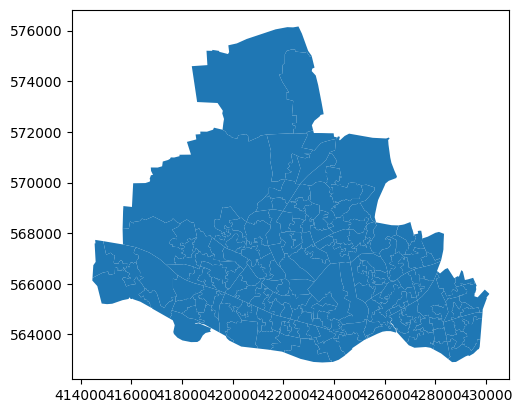

In [28]:
# Check for missing LSOAs/check shape looks right
newcastle.plot()

### Subsetting/Preparing Age Dataset

The age data needs to be filtered to only include the range of ages required for this study. This range is across two columns in the original data, so these must be aggregated. Once ready, a histogram is used to inspect the distribution of the data and check for extreme values. In this case, the histogram shows that many of the Newcastle LSOA populations are made up of between 10-20%, 20-29 year olds.

In [29]:
# Subset age data to prepare for merge
# Include only ages between 20-24 & 25-29
age_sub = age[['mnemonic', 'Total', 'Aged 20 to 24 years', 'Aged 25 to 29 years']]

In [30]:
# Rename some columns for readability
age_sub = age_sub.rename(columns={'mnemonic': 'LSOA21CD',
                                  'Total': 'total_pop',
                                  'Aged 20 to 24 years': 'age_20_24',
                                  'Aged 25 to 29 years': 'age_25_29'})

In [31]:
# Create columns for ages 20 - 29 and percentage
age_sub['age_20_29'] = age_sub['age_20_24'] + age_sub['age_25_29']
age_sub['pct_20_29'] = age_sub['age_20_29'] / age_sub['total_pop'] * 100

In [32]:
# Check results
age_sub.head()

,LSOA21CD,total_pop,age_20_24,age_25_29,age_20_29,pct_20_29
0,E01008309,1786,56,62,118,6.606943
1,E01008352,1440,68,106,174,12.083333
2,E01008357,1525,50,56,106,6.950820
3,E01008358,1707,134,263,397,23.257176
4,E01033550,2054,73,68,141,6.864654


In [33]:
# Basic descriptive statistics
age_sub.describe()

,total_pop,age_20_24,age_25_29,age_20_29,pct_20_29
count,180.000000,180.000000,180.000000,180.000000,180.000000
mean,1667.255556,203.566667,129.944444,333.511111,18.525330
std,420.075760,299.596975,69.699813,343.066642,14.872753
min,1047.000000,39.000000,33.000000,85.000000,6.518405
25%,1406.500000,66.000000,78.000000,154.000000,10.649015
50%,1559.000000,85.500000,110.000000,199.000000,12.816427
75%,1818.500000,144.250000,159.250000,309.500000,16.358252
max,3962.000000,1537.000000,458.000000,1724.000000,78.419593


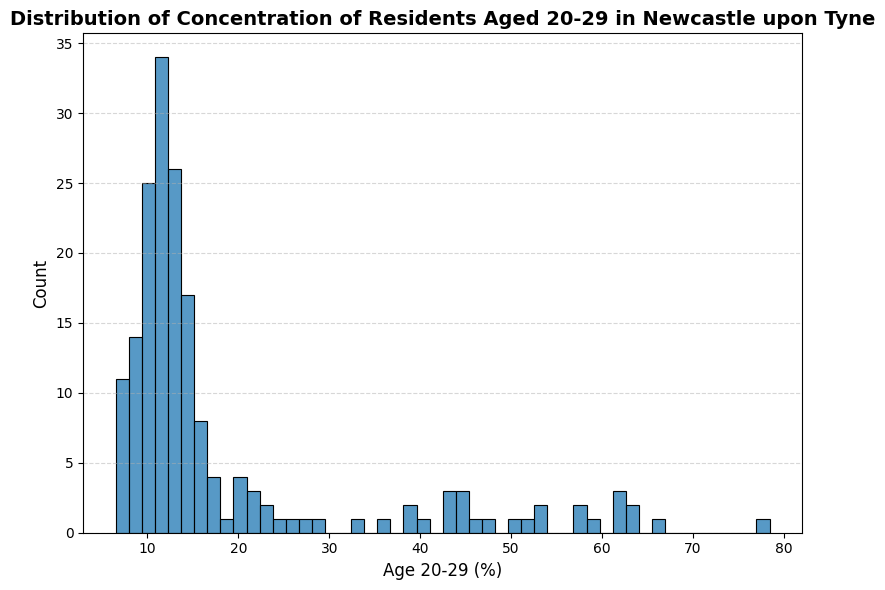

In [34]:
plt.figure(figsize=(8,6))

# Create histplot to determine distribution of the data
sns.histplot(data=age_sub,
            x='pct_20_29',
            bins=50,)

# Styling
plt.title('Distribution of Concentration of Residents Aged 20-29 in Newcastle upon Tyne', fontsize=14, fontweight='bold')
plt.xlabel('Age 20-29 (%)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5) # Improve readability of counts
plt.tight_layout()
plt.show()

In [35]:
# Merge to Newcastle dataset
age_newc = newcastle.merge(age_sub, on='LSOA21CD', how='inner')

In [36]:
# Inspect top of data
age_newc.head()

,LSOA21CD,LSOA21NM,LSOA21NMW,BNG_E,BNG_N,LAT,LONG,GlobalID,geometry,LAD22CD,LAD22NM,total_pop,age_20_24,age_25_29,age_20_29,pct_20_29
0,E01008288,Newcastle upon Tyne 027A,None,420626,564662,54.9762,-1.67931,12984595-436a-41f7-a366-8ff4885730c2,"POLYGON ((420666.966 565211.318, 420970.356 56...",E08000021,Newcastle upon Tyne,1344,56,85,141,10.491071
1,E01008289,Newcastle upon Tyne 027B,None,421257,564713,54.9766,-1.66944,c62b4361-53a1-46f3-a875-c96423a60d52,"POLYGON ((421550.866 564815.62, 421503.094 564...",E08000021,Newcastle upon Tyne,1742,97,101,198,11.366246
2,E01008290,Newcastle upon Tyne 027C,None,421354,563785,54.9682,-1.66800,4ac45623-e574-4937-95e6-7b11a2cfbd37,"POLYGON ((421593.016 564188.025, 421825.056 56...",E08000021,Newcastle upon Tyne,1697,101,166,267,15.733648
3,E01008291,Newcastle upon Tyne 027D,None,422274,563691,54.9674,-1.65363,39054168-4993-4657-afe7-1ab84fda97ac,"POLYGON ((422201.387 563955.07, 422456.374 563...",E08000021,Newcastle upon Tyne,2098,150,134,284,13.536702
4,E01008292,Newcastle upon Tyne 027E,None,420439,565029,54.9795,-1.68220,26131526-e859-4012-b111-1b0a3a0b97fe,"POLYGON ((420591.717 565122.304, 420647.317 56...",E08000021,Newcastle upon Tyne,1286,63,78,141,10.964230


### Subsetting/Preparing House Price Data

The house price dataset required the most preprocessing before being ready to merge with the main dataframe, beginning with filtering to only the 2021 data. From inspecting the top of the dataset, looking at the dtypes, and reading the metadata, it's clear that the price data needs to be standardised before it can be used for analysis, by removing commas and symbols used in place of null values. However, since there are missing values in the housing data it can't be used in the regression as missing values must either be dropped or return an error (Perktold and Seabold, 2024). Despite this, the missing values were still needed for the choropleths, since creating estimates in LSOAs with few transactions would create artificial patterns. Therefore, two datasets were made, one with no missing values to be used in regression, and one retaining the missing values to be used in mapping.

In [37]:
# Subset age data to prepare for merge
# Include data for 2021 only - same year as age data
house_sub = house_price[['LSOA code', 'Year ending Dec 2021']]

In [38]:
# Rename columns
house_sub = house_sub.rename(columns={'LSOA code': 'LSOA21CD',
                                      'Year ending Dec 2021': 'med_price_dec_21'})

In [39]:
# Inspect top of subset
house_sub.head()

,LSOA21CD,med_price_dec_21
0,E01011949,"101,500"
1,E01011950,"50,159"
2,E01011951,"60,000"
3,E01011952,"80,000"
4,E01011953,"92,500"


In [40]:
# Basic into - dtypes etc
house_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LSOA21CD          34753 non-null  object
 1   med_price_dec_21  34753 non-null  object
dtypes: object(2)
memory usage: 543.1+ KB


In [41]:
# Standardise values in price column
house_sub["med_price_dec_21"] = (
    house_sub["med_price_dec_21"]
    .astype(str)
    .str.replace(",", "") # Remove commas in prices
    .replace("..", "") # Remove symbols included to denote missing data
    .replace(":", "")
    .replace({"": None}) # Convert leftover empty strings
    .astype(float) # Convert to number
)

In [42]:
# Check updated dtype
house_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34753 entries, 0 to 34752
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   LSOA21CD          34753 non-null  object 
 1   med_price_dec_21  34234 non-null  float64
dtypes: float64(1), object(1)
memory usage: 543.1+ KB


In [43]:
# Check results
house_sub.head()

,LSOA21CD,med_price_dec_21
0,E01011949,101500.0
1,E01011950,50159.0
2,E01011951,60000.0
3,E01011952,80000.0
4,E01011953,92500.0


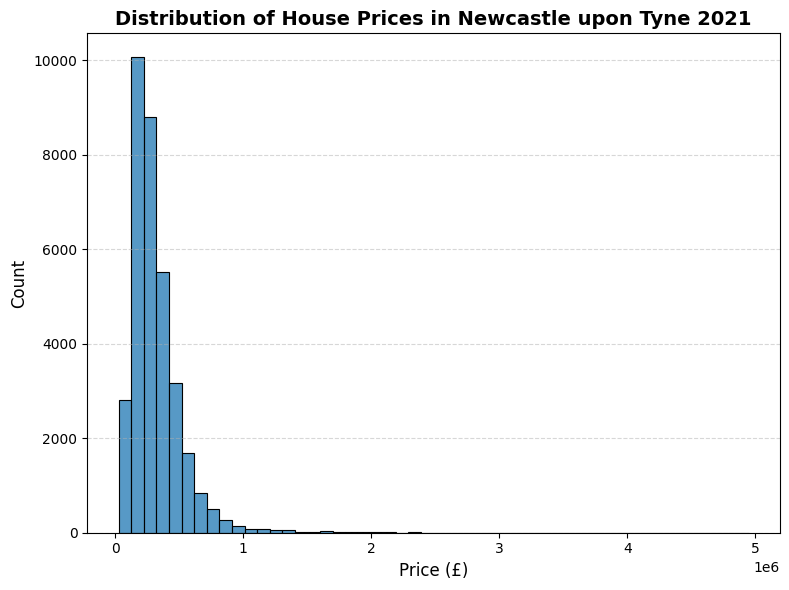

In [44]:
plt.figure(figsize=(8,6))

# Create histplot to determine distribution of the data
sns.histplot(data=house_sub,
            x='med_price_dec_21',
            bins=50,)

# Styling
plt.title('Distribution of House Prices in Newcastle upon Tyne 2021', fontsize=14, fontweight='bold')
plt.xlabel('Price (£)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5) # Improve readability of counts
plt.tight_layout()
plt.show()

In [45]:
# Check for missing values
house_sub['med_price_dec_21'].isnull().sum()

np.int64(519)

In [59]:
# Export smaller file to allow upload to GitHub
house_sub.to_csv("newcastle_house_prices.csv", index=False)

In [46]:
# Create final df to be used for choropleths
df_geo = age_newc.merge(house_sub, on='LSOA21CD', how='left')

In [47]:
# Contains missing data
df_geo['med_price_dec_21'].isnull().sum()

np.int64(19)

In [48]:
# Create df to be used for regression - drop missing values
df_reg = df_geo.dropna(subset=['med_price_dec_21'])

In [49]:
# Check results
df_reg.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 161 entries, 0 to 168
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   LSOA21CD          161 non-null    object  
 1   LSOA21NM          161 non-null    object  
 2   LSOA21NMW         0 non-null      object  
 3   BNG_E             161 non-null    int64   
 4   BNG_N             161 non-null    int64   
 5   LAT               161 non-null    float64 
 6   LONG              161 non-null    float64 
 7   GlobalID          161 non-null    object  
 8   geometry          161 non-null    geometry
 9   LAD22CD           161 non-null    object  
 10  LAD22NM           161 non-null    object  
 11  total_pop         161 non-null    int64   
 12  age_20_24         161 non-null    int64   
 13  age_25_29         161 non-null    int64   
 14  age_20_29         161 non-null    int64   
 15  pct_20_29         161 non-null    float64 
 16  med_price_dec_21  161 n

## Regression

To determine whether the concentration of young adults per LSOA is associated with house price, an OLS regression model was implemented. This model is well suited to the task, since it is used to estimate the relationship between and independent and dependent variable (Waples, 2025), in this case the ages and house prices respectively.

Before fitting the model, a scatter plot is used to visually examine the relationship between variables. In this case, no clear relationship can be observed. This is confirmed by the results of the regression, with the p-value showing that the relationship is not significant, and the R-squared value suggesting that the age explains none of the variation present in house prices across the LSOAs.

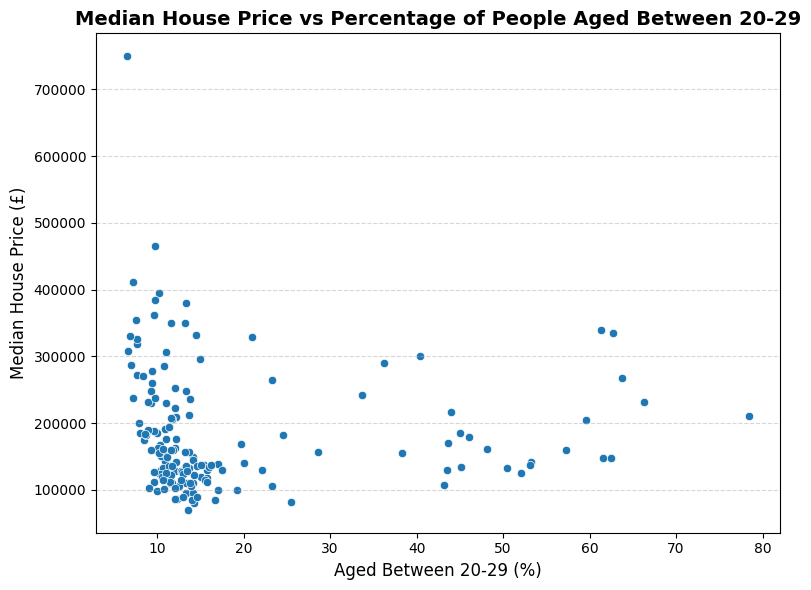

In [50]:
plt.figure(figsize=(8,6))

# Scatterplot to determine relationship before regression
sns.scatterplot(data=df_reg, x='pct_20_29', y='med_price_dec_21')

# Styling
plt.title('Median House Price vs Percentage of People Aged Between 20-29',fontsize=14, fontweight='bold')
plt.xlabel('Aged Between 20-29 (%)', fontsize=12)
plt.ylabel('Median House Price (£)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [51]:
# Define independent and dependent variables
X = df_reg[['pct_20_29']]
y = df_reg['med_price_dec_21']

# Add a constant (intercept) to the independent variable
X = sm.add_constant(X)

In [52]:
# OLS regression model
ols_model = sm.OLS(y, X).fit()

In [53]:
# OLS regression summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       med_price_dec_21   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.06899
Date:                Fri, 06 Feb 2026   Prob (F-statistic):              0.793
Time:                        12:02:10   Log-Likelihood:                -2069.5
No. Observations:                 161   AIC:                             4143.
Df Residuals:                     159   BIC:                             4149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.866e+05   1.16e+04     16.099      0.0

## Visualisation

### Non-Spatial - Academic Audience

For a non-spatial visualisation, a scatterplot with a regression line has been used to supplement the results of the regression model. This plot is intended to be read by an academic audience, in conjunction with the results of the regression above. The plot is minimal and the regression line is almost completely flat, demonstrating the lack of a linear trend between these variables. Additionally, a simple blue / orange colour palette has been used, due to it not only being colourblind friendly but also offering a strong contrast between the points and the regression line. The markers have been changed to diamonds since the angular shape makes it easier to distinguish between overlapping points, to this end the opacity of the markers has also been decreased to enable clearer interpretation of the graph. This visualisation is intended to complement the regression analysis summary shown above, as it is both more readable and accessible.

<Figure size 800x600 with 0 Axes>

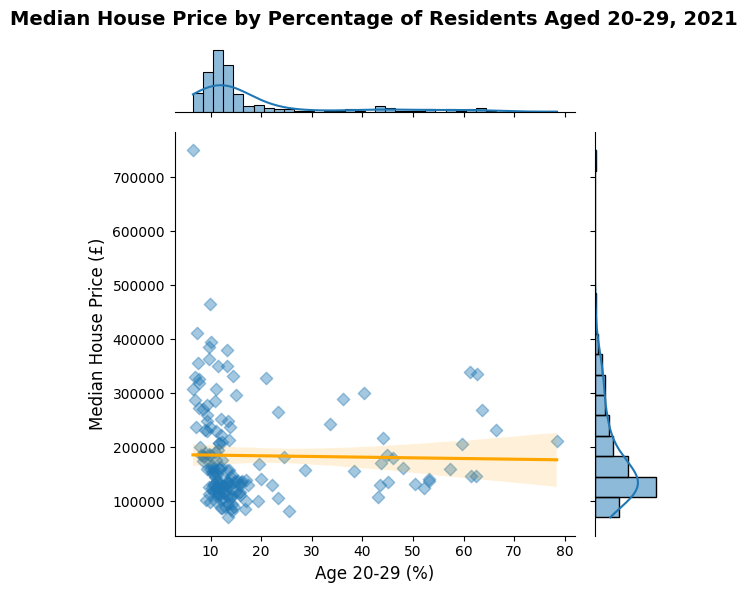

In [54]:
plt.figure(figsize=(8,6))

# Joint plot to visualise the relationship between age and median price
sns.jointplot(data=df_geo, x="pct_20_29", y="med_price_dec_21",
              kind='reg',
              marker='D', # Styling so easier to see overlapping points
              scatter_kws={'s': 40,
                           'alpha': 0.4},
              line_kws={'color': 'orange'}) # Easy to see against blue points

# Styling
plt.suptitle('Median House Price by Percentage of Residents Aged 20-29, 2021', fontsize=14, fontweight='bold')
plt.xlabel('Age 20-29 (%)', fontsize=12)
plt.ylabel('Median House Price (£)', fontsize=12)
plt.tight_layout()
plt.show()

### Spatial - Policy Maker / Public Audience

Choropleth maps have been made as a spatial visualisation for policy maker and public audiences, as these are unlikely to have specialist statistical knowledge. The maps echo the results shown in the regression, but present them in a much more digestible format for general audiences. To aid in accessibility, a sequential, colourblind friendly colourmap has been chosen in the form of 'cividis' which is an optimised version of the 'viridis' colourmap (Nuñez et al., 2018). To keep the maps as clear as possible, additional contextual elements such as basemaps and North arrows were removed as these gave the maps a cluttered appearance and did not align with the intuitive nature these maps aim to capture.

For the house price data, missing values have been retained as mentioned above, to avoid introducing false patterns in the data. However, to maintain clarity in the map the missing data has been clearly styled so as to not be mistaken as part of the colourmap or dataset. The house price data has also been clustered using equal intervals, this helps to show broad patterns across the city while maintaining an intuitive key for people to follow. The titles and legends have also been styled to ensure that no specialist or technical knowledge is required to interpret the spatial patterns in the maps.

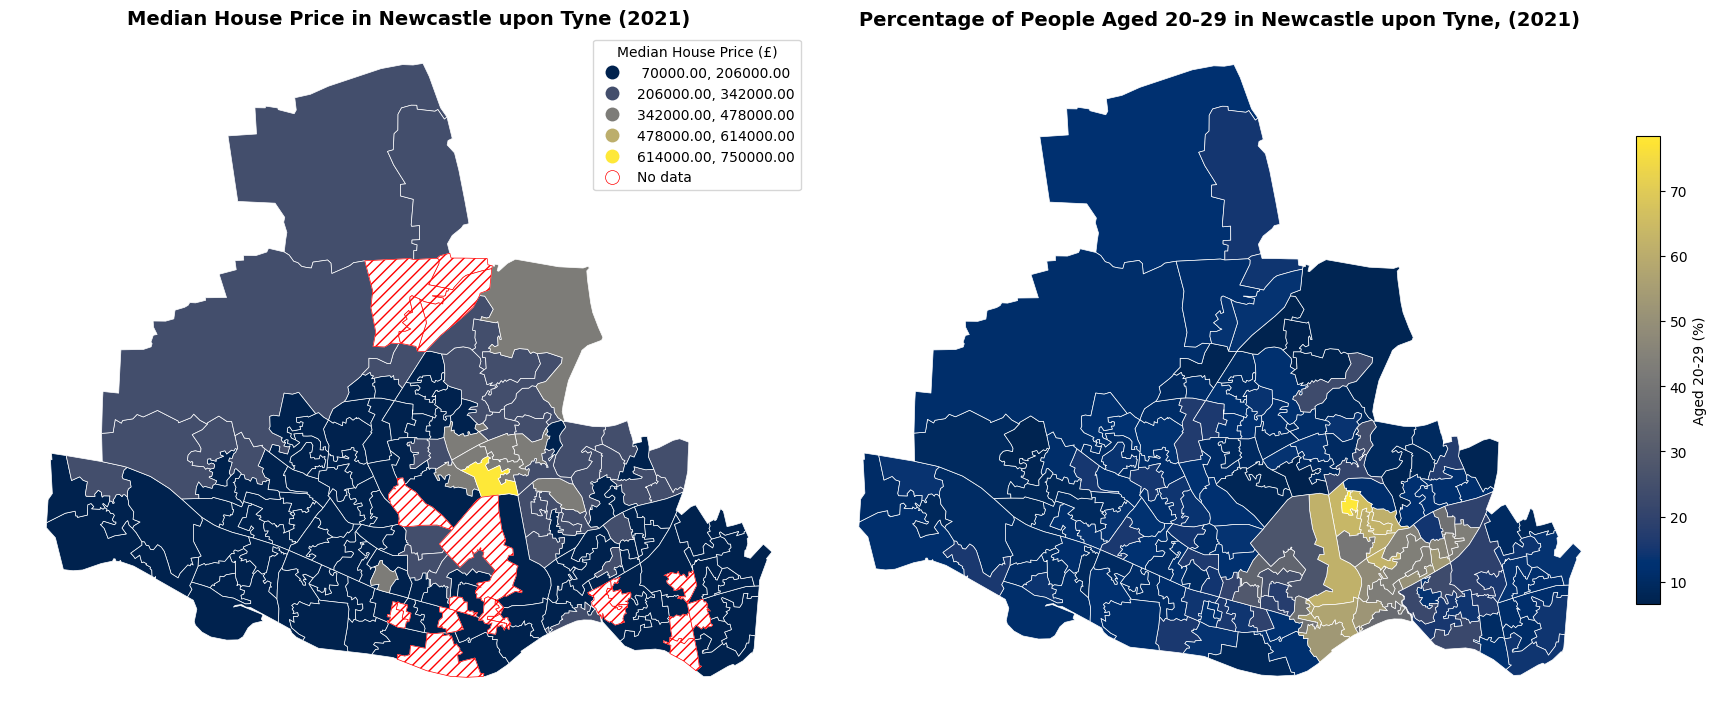

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(18,12),
                       gridspec_kw={'width_ratios': [1, 1.2]}) # Ensure age plot is not 'squished' by colourbar

# Create plot 1
base = df_geo.plot(ax=ax[0],
                       column = 'med_price_dec_21',
                       cmap = 'cividis', # Select colourblind friendly cmap
                       scheme='equal_interval',
                       k=5,
                       edgecolor='white', # Show clearer boundaries
                       linewidth=0.5,
                       legend='True',
                       missing_kwds={ # Handle missing values for mapping
                           'color': 'white',
                           'edgecolor': 'red', # Use colour not included in cmap
                           'hatch': '///', # Distinct so not mistaken for values in dataset
                           'label': 'No data'
                       })

# Create plot 2
base = age_newc.plot(ax=ax[1],
                       column = 'pct_20_29',
                       cmap = 'cividis',
                       edgecolor='white', # Show clearer boundaries
                       linewidth=0.5,
                       categorical=False,
                       legend=True,
                       legend_kwds={'shrink':0.4,
                                    'label':'Aged 20-29 (%)',
                                    'pad': 0.02}) # Style legend to be less intrusive, label for context

# Remove the axis for both plots
ax[0].set_axis_off()
ax[1].set_axis_off()

# Add titles to plots
ax[0].set_title('Median House Price in Newcastle upon Tyne (2021)', fontsize=14, fontweight='bold')
ax[1].set_title('Percentage of People Aged 20-29 in Newcastle upon Tyne, (2021)', fontsize=14, fontweight='bold')

# Title legend for median house price
ax[0].get_legend().set_title('Median House Price (£)')

plt.tight_layout()
plt.show()

## Conclusion

Overall, the results of the regression paired with the visualisations show that the spatial distribution of young adults in Newcastle upon Tyne is not strongly associated with median house prices in a linear manner. The choropleths show that the areas with the highest concentrations of young adults are clustered around the city centre. This could be due to young people living near workplaces, renting nearer to amenities, or high populations of university students, rather than access to cheaper housing markets. This highlights a need for policy makers to investigate rental affordability and the broader factors affecting young peoples' housing options on a city wide basis.

## References

* Brader, C. 2024. Housing needs of young people. House of Lords Library. [Online]. Available from: https://lordslibrary.parliament.uk/housing-needs-of-young-people/.
* Nuñez, J.R., Anderton, C.R. and Renslow, R.S. 2018. Optimizing colormaps with consideration for color vision deficiency to enable accurate interpretation of scientific data J. Malo, ed. PLOS ONE. 13(7), p.e0199239.
* Office for National Statistics 2023a. Local Authority Districts (April 2023) Names and Codes in the UK. Statistics.gov.uk. [Online]. [Accessed 6 February 2026]. Available from: https://geoportal.statistics.gov.uk/datasets/ons::local-authority-districts-april-2023-names-and-codes-in-the-uk/explore?showTable=true.
* Office for National Statistics 2021a. Lower layer Super Output Areas (December 2021) Boundaries EW BGC (V5). Statistics.gov.uk. [Online]. Available from: https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2021-boundaries-ew-bgc-v5-2/about.
* Office for National Statistics 2021b. LSOA (2021) to BUA to LAD to Region (December 2022) Best Fit Lookup in EW (V2). Statistics.gov.uk. [Online]. Available from: https://geoportal.statistics.gov.uk/datasets/ons::lsoa-2021-to-bua-to-lad-to-region-december-2022-best-fit-lookup-in-ew-v2/about.
* Office for National Statistics 2023b. Median house prices by lower layer super output area: HPSSA dataset 46 - Office for National Statistics. Ons.gov.uk. [Online]. Available from: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbylowerlayersuperoutputareahpssadataset46/current.
* Office for National Statistics n.d. Nomis - Official Labour Market Statistics. www.nomisweb.co.uk. [Online]. Available from: https://www.nomisweb.co.uk/query/construct/summary.asp?menuopt=200&subcomp=.
* Perktold, J. and Seabold, S. 2024. statsmodels.regression.linear_model.OLS - statsmodels 0.14.4. Statsmodels.org. [Online]. [Accessed 6 February 2026]. Available from: https://www.statsmodels.org/v0.14.4/generated/statsmodels.regression.linear_model.OLS.html#statsmodels.regression.linear_model.OLS.
* Waples, J. 2025. OLS Regression: The Key Ideas Explained. Datacamp.com. [Online]. Available from: https://www.datacamp.com/tutorial/ols-regression.

## Data Sources

* Office for National Statistics 2021a. Lower layer Super Output Areas (December 2021) Boundaries EW BGC (V5). Statistics.gov.uk. [Online]. Available from: https://geoportal.statistics.gov.uk/datasets/ons::lower-layer-super-output-areas-december-2021-boundaries-ew-bgc-v5-2/about.
* Office for National Statistics 2021b. LSOA (2021) to BUA to LAD to Region (December 2022) Best Fit Lookup in EW (V2). Statistics.gov.uk. [Online]. Available from: https://geoportal.statistics.gov.uk/datasets/ons::lsoa-2021-to-bua-to-lad-to-region-december-2022-best-fit-lookup-in-ew-v2/about.
* Office for National Statistics 2023. Median house prices by lower layer super output area: HPSSA dataset 46 - Office for National Statistics. Ons.gov.uk. [Online]. Available from: https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbylowerlayersuperoutputareahpssadataset46/current.
* Office for National Statistics n.d. Nomis - Official Labour Market Statistics. www.nomisweb.co.uk. [Online]. Available from: https://www.nomisweb.co.uk/query/construct/summary.asp?menuopt=200&subcomp=.